In [10]:
from IPython import get_ipython
ipython = get_ipython()
ipython.magic('load_ext autoreload')
ipython.magic('autoreload 2')

import os
import numpy as np
import scipy.spatial.distance as sdst
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F 

from biodl.deephd.dhd_data import _load_idx, load_one_sample


In [17]:
def get_dst_mat(sample: dict) -> dict:
    ret = {}
    for atom_type in ('ca', 'cb'):
        tmp_ = []
        x1, x2 = sample[f'coords_{atom_type}']
        dst_x1x1 = sdst.cdist(x1, x1).astype(np.float32)
        dst_x1x2 = sdst.cdist(x1, x2).astype(np.float32)
        tmp_.append(dst_x1x1)
        tmp_.append(dst_x1x2)
        ret[atom_type] = tmp_ 
    return ret


In [18]:
path_idx = '/home/ar/data/bioinformatics/deep_hd/idxok_debug0.txt'
data_idx = _load_idx(path_idx)


In [19]:
sample = load_one_sample(data_idx.iloc[0])
sample_dst = get_dst_mat(sample)


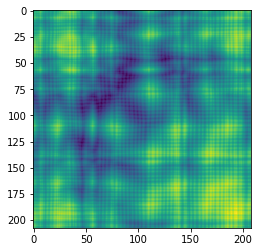

In [26]:
plt.imshow(sample_dst['ca'][1])

In [51]:
class ConvBlock_VGG(nn.Module):

    def __init__(self, in_channels,
                 out_channels,
                 kernel_size=3,
                 num_conv=1,
                 act: str = 'prelu',
                 use_bn=True,
                 padding='same'):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        layers_ = []
        for idx in range(num_conv):
            if idx == 0:
                chn_ = in_channels
            else:
                chn_ = out_channels
            if padding == 'same':
                pad_ = kernel_size // 2
            else:
                pad_ = 0
            conv_ = nn.Conv2d(in_channels=chn_, out_channels=out_channels, kernel_size=kernel_size, padding=pad_)
            layers_.append(conv_)
            if use_bn:
                layers_.append(nn.BatchNorm2d(num_features=out_channels))
            if act.lower() == 'relu':
                layers_.append(nn.ReLU())
            elif act.lower() == 'prelu':
                layers_.append(nn.PReLU())
            else:
                raise NotImplementedError('not supported activation [{}]'.format(act))
        self.body = nn.Sequential(*layers_)

    def forward(self, input):
        ret_ = self.body(input)
        return ret_


class AttentionModel(nn.Module):
    
    def __init__(self, inp_size: int = 3, out_size: int = 1):
        super().__init__()
        self.inp_size = inp_size
        self.out_size = out_size
        self.conv1 = ConvBlock_VGG(in_channels=self.inp_size, out_channels=32, num_conv=2)
        self.conv2 = ConvBlock_VGG(in_channels=32, out_channels=64, num_conv=2)
        self.conv3 = ConvBlock_VGG(in_channels=64*2, out_channels=64, num_conv=2)
        self.conv4 = ConvBlock_VGG(in_channels=64*2, out_channels=64, num_conv=2)
        self.sub_max_x2 = nn.MaxPool2d(3, stride=2, padding=1)
        # self.sub_max_x3 = nn.MaxPool2d(5, stride=3, padding=1)
        self.sub_avg_x2 = nn.AvgPool2d(3, stride=2, padding=1)
        # self.sub_avg_x3 = nn.AvgPool2d(5, stride=3, padding=1)
    
    def forward(self, x):
        # stage1
        x = self.conv1(x)
        x_max, x_max = self.sub_max_x2(x), self.sub_avg_x2(x)
        x = torch.cat([x_max, x_max], dim=1)
        # stage2
        x = self.conv2(x)
        x_max, x_max = self.sub_max_x2(x), self.sub_avg_x2(x)
        x = torch.cat([x_max, x_max], dim=1)
        # stage3
        x = self.conv3(x)
        x_max, x_max = self.sub_max_x2(x), self.sub_avg_x2(x)
        x = torch.cat([x_max, x_max], dim=1)
        # stage4
        x = self.conv4(x)
        x_max, x_max = self.sub_max_x2(x), self.sub_avg_x2(x)
        x = torch.cat([x_max, x_max], dim=1)
        


In [48]:
x = torch.rand([1, 3, 64, 64])


In [52]:
m = AttentionModel()


In [53]:
y = m(x)
y.shape


RuntimeError: Given groups=1, weight of size 64 32 3 3, expected input[1, 64, 32, 32] to have 32 channels, but got 64 channels instead

In [31]:
64/3



21.333333333333332

In [35]:
3**6


729